In [1]:
import numpy as np
import pandas as pd
import re

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn import feature_extraction
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import hdbscan

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brandon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = stopwords.words('english')

In [3]:
print(stopwords[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [4]:
stemmer = SnowballStemmer("english")

In [5]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            if len(token) >= 4:
                filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            if len(token) >= 4:
                filtered_tokens.append(token)
    return filtered_tokens

In [6]:
df = pd.read_csv('SecDef_Speeches.csv')

In [7]:
totalvocab_stemmed = []
totalvocab_tokenized = []

for i in df.speech:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)

    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [8]:
vocab = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('There are ' + str(vocab.shape[0]) + ' items in our vocabulary.')

There are 302045 items in our vocabulary.


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.1, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(df.speech) #fit the vectorizer to speeches

print(tfidf_matrix.shape)

CPU times: user 11.9 s, sys: 101 ms, total: 12 s
Wall time: 12 s
(204, 1593)


In [10]:
terms = tfidf_vectorizer.get_feature_names()

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [12]:
from sklearn.cluster import KMeans

num_clusters = 12

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 8.42 s, sys: 1.59 s, total: 10 s
Wall time: 2.59 s


In [13]:
df['cluster'] = clusters

In [14]:
df.groupby('cluster')['cluster'].count()

cluster
0     19
1     22
2     17
3     13
4     23
5     34
6     15
7      4
8     19
9     14
10     7
11    17
Name: cluster, dtype: int64

In [15]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [16]:
print("{0}Top terms per cluster:{1}".format(color.BOLD,color.END))
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("{0}Cluster {1} Words:{2}".format(color.BLUE + color.BOLD, i, color.END))
    
    for ind in order_centroids[i, :10]:
        word = str(vocab.loc[terms[ind].split(' ')].values.tolist()[0][0])
        print('\t-{0}'.format(word))
    print('')
    
    print("{0}Cluster {1} Speech Titles:\n{2}".format(color.GREEN + color.BOLD, i, color.END))
    titles = df[df['cluster'] == i].title
    for title in titles[:10]:
        print('\t- {0}'.format(title[:100]))
    print('\n\n')
    
print('\n')

Top terms per cluster:

Cluster 0 Words:
	-budget
	-investing
	-billions
	-sequestration
	-reforming
	-capable
	-fiscal
	-future
	-technologies
	-congress

Cluster 0 Speech Titles:

	- Submitted Statement -- Senate Appropriations Committee-Defense (FY 2017 Budget Request)
	- Opening Statement -- Senate Armed Services Committee (FY 2017 Budget Request)
	- Opening Statement -- House Appropriations Committee-Defense (FY 2017 Budget Request)
	- Submitted Statement -- Senate Appropriations Committee-Defense (Budget Request)
	- Submitted Statement -- Senate Armed Services Committee (Budget Request)
	- Remarks Previewing the FY 2017 Defense Budget
	- Reagan National Defense Forum Keynote
	- Submitted Statement -- House Armed Services Committee (FY 2017 Budget Request)
	- Opening Statement -- House Armed Services Committee (FY 2017 Budget Request)
	- Opening Statement -- Senate Appropriations Committee-Defense (FY 2017 Budget Request)



Cluster 1 Words:
	-secretary
	-family
	-president
	-serv

	-general
	-army
	-command
	-family
	-marines
	-marked
	-operating
	-leadership
	-soldiers
	-afghanistan

Cluster 11 Speech Titles:

	- Remarks at the Opening Ceremony of the 2015 Warrior Games
	- U.S. Special Operations Command Change of Command
	- Remarks before Administering the Oath of Office to Secretary of the Army Eric Fanning
	- Remarks at the Arrival Ceremony for Secretary of the Army Eric Fanning
	- Army Chief of Staff Change of Responsibility
	- Retirement Ceremony of General John "Jay" Paxton
	- Remarks at the Chief of Staff of the Air Force Retirement Ceremony
	- Army & Navy Personnel Announcement
	- Remarks Introducing Afghan President Ashraf Ghani
	- U.S. Transportation Command Assumption of Command







Let's use t-Distributed Stochastic Neighbor Embedding, or [t-SNE ](https://lvdmaaten.github.io/tsne/), for dimensionality reduction. This let's us project highly dimensional data, such as our tfidf matrix, into 2 dimensional space.

In [17]:
data = tfidf_matrix.toarray()
projection = TSNE().fit_transform(data)

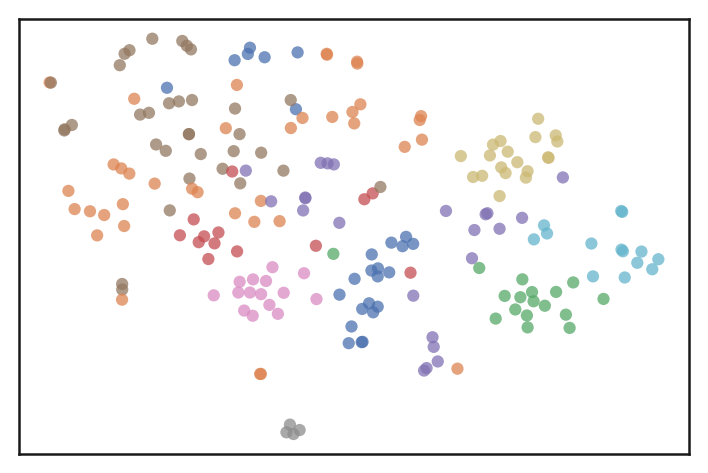

In [18]:
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'marker': 'o', 'alpha' : 0.75, 's' : 150, 'linewidths':0}

labels = clusters
palette = sns.color_palette(palette='deep', n_colors=np.unique(labels).max() + 1)
colors = [palette[x] if x >= 0 else (0.75, 0.75, 0.75) for x in labels]

fig, ax = plt.subplots(figsize=(12, 8))
ax.margins(0.05)

plt.scatter(*projection.T, c=colors, **plot_kwds)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)


plt.show()

Here we can set the minimum number of speeches in a cluster. Let's select 4, which would dictate that we have at least 4 speeches in a cluster. `min_samples` is a measure of how conservative we would like the clustering to be--setting this value to `1` means we will not look at just high density clusters.

In [19]:
model = hdbscan.HDBSCAN(min_cluster_size=4, min_samples=1)

In [20]:
labels = model.fit_predict(tfidf_matrix)

In [21]:
if -1 in labels:
    num_clusters = len(set(labels)) - 1
else:
    num_clusters = len(set(labels))
    
num_noise = len([i for i in labels if i == -1])
    
print("HDBSCAN found {0} clusters".format(num_clusters))
print("{0} speeches were considered 'noise' and were not clustered.".format(num_noise))

HDBSCAN found 18 clusters
101 speeches were considered 'noise' and were not clustered.


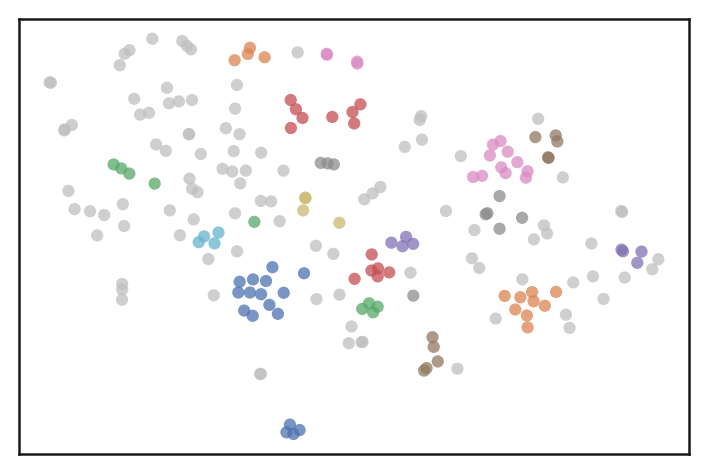

In [22]:
palette = sns.color_palette(palette='deep', n_colors=np.unique(labels).max() + 1)
colors = [palette[x] if x >= 0 else (0.75, 0.75, 0.75) for x in labels]

fig, ax = plt.subplots(figsize=(12, 8))
ax.margins(0.05)

plt.scatter(*projection.T, c=colors, **plot_kwds)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)


plt.show()